In [4]:
#!/usr/bin/env python
# coding: utf-8
 
# This script generates the MINICIFAR dataset from CIFAR10
# The following parameters can be changed : 
# n_classes (between 2 and 10) 
# Reduction factor R (which will result in 10000 /  R examples per class for the train set, and 1000 / R per class for test)
# --
 
 
n_classes_minicifar = 4
train_size = 0.8
R = 5
 
 
# Download the entire CIFAR10 dataset
 
from torchvision.datasets import CIFAR10
import numpy as np 
from torch.utils.data import Subset
from torch.utils.data.sampler import SubsetRandomSampler
 
 
import torchvision.transforms as transforms
 
## Normalization is different when training from scratch and when training using an imagenet pretrained backbone
 
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
 
normalize_forimagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
 
# Data augmentation is needed in order to train from scratch
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])
 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])
 
## No data augmentation when using Transfer Learning 
## however resize to Imagenet input dimensions is recommended for Transfer learning
transform_train_imagenet = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    normalize_forimagenet,
])
 
transform_test_imagenet = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    normalize_forimagenet,
])
 
 
### The data from CIFAR10 will be downloaded in the following dataset
rootdir = './data/cifar10'
 
c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)


 
c10train_imagenet = CIFAR10(rootdir,train=True,download=True,transform=transform_train_imagenet)
c10test_imagenet = CIFAR10(rootdir,train=False,download=True,transform=transform_test_imagenet)
 
# Generating Mini-CIFAR
# 
# CIFAR10 is sufficiently large so that training a model up to the state of the art performance will take approximately 3 hours on the 1060 GPU available on your machine. 
# As a result, we will create a "MiniCifar" dataset, based on CIFAR10, with less classes and exemples. 
 
def train_validation_split(train_size, num_train_examples):
    # obtain training indices that will be used for validation
    indices = list(range(num_train_examples))
    np.random.shuffle(indices)
    idx_split = int(np.floor(train_size * num_train_examples))
    train_index, valid_index = indices[:idx_split], indices[idx_split:]
 
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)
 
    return train_sampler,valid_sampler
 
def generate_subset(dataset,n_classes,reducefactor,n_ex_class_init):
 
    nb_examples_per_class = int(np.floor(n_ex_class_init / reducefactor))
    # Generate the indices. They are the same for each class, could easily be modified to have different ones. But be careful to keep the random seed! 
 
    indices_split = np.random.RandomState(seed=42).choice(n_ex_class_init,nb_examples_per_class,replace=False)
 
 
    all_indices = []
    for curclas in range(n_classes):
        curtargets = np.where(np.array(dataset.targets) == curclas)
        indices_curclas = curtargets[0]
        indices_subset = indices_curclas[indices_split]
        #print(len(indices_subset))
        all_indices.append(indices_subset)
    all_indices = np.hstack(all_indices)
    
    return Subset(dataset,indices=all_indices)
    
 
 
### These dataloader are ready to be used to train for scratch 
minicifar_train= generate_subset(dataset=c10train,n_classes=n_classes_minicifar,reducefactor=R,n_ex_class_init=5000)
num_train_examples=len(minicifar_train)
train_sampler,valid_sampler=train_validation_split(train_size, num_train_examples)
minicifar_test = generate_subset(dataset=c10test,n_classes=n_classes_minicifar,reducefactor=1,n_ex_class_init=1000) 
 
 
### These dataloader are ready to be used to train using Transfer Learning 
### from a backbone pretrained on ImageNet
minicifar_train_im= generate_subset(dataset=c10train_imagenet,n_classes=n_classes_minicifar,reducefactor=R,n_ex_class_init=5000)
num_train_examples_im=len(minicifar_train_im)
train_sampler_im,valid_sampler_im=train_validation_split(train_size, num_train_examples_im)
minicifar_test_im= generate_subset(dataset=c10test_imagenet,n_classes=n_classes_minicifar,reducefactor=1,n_ex_class_init=1000)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

# test()

In [6]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data.dataloader import DataLoader

c10train_sampler,c10valid_sampler=train_validation_split(0.8, len(c10train))

c10trainloader = DataLoader(c10train,batch_size=32,sampler=c10train_sampler)
c10validloader = DataLoader(c10train,batch_size=32,sampler=c10valid_sampler)
c10testloader = DataLoader(c10test,batch_size=32)
#from minicifar import minicifar_train,minicifar_test,train_sampler,valid_sampler


trainloader = DataLoader(minicifar_train,batch_size=32,sampler=train_sampler)
validloader = DataLoader(minicifar_train,batch_size=32,sampler=valid_sampler)
testloader = DataLoader(minicifar_test,batch_size=32)

# Notre production 

In [ ]:
from torch import nn, optim
import torchvision
import torch.optim as optim
from google.colab import files


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss(test_loss,training_loss,n_epochs) : 
  plt.figure()
  test_ax=np.arange(0,n_epochs,n_epochs/len(test_loss))
  train_ax=np.arange(0,n_epochs,n_epochs/len(training_loss))

  plt.plot(test_ax,test_loss,"r")
  plt.plot(train_ax,training_loss)
  plt.xlabel('epoch')
  plt.ylabel('loss') 


In [ ]:
def plot_log_loss(test_loss,training_loss,n_epochs) : 
  plt.figure()
  test_ax=np.arange(0,n_epochs,n_epochs/len(test_loss))
  train_ax=np.arange(0,n_epochs,n_epochs/len(training_loss))

  plt.plot(test_ax,np.log(np.array(test_loss)),"r")
  plt.plot(train_ax,np.log(np.array(training_loss)))
  plt.xlabel('epoch')
  plt.ylabel('log(loss)')   


In [ ]:

def print_accuracy(net,testloader ) : 
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():  # torch.no_grad for TESTING
        for data in testloader:
            images, labels = data
            if data_int :
              images=images.half()
            images=images.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    

    class_correct = list(0. for i in range(4))
    class_total = list(0. for i in range(4))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if data_int :
              images=images.half()
            images=images.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels.to(device)).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    classes = ('1', '2', '3', '4')
    for i in range(4):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
def eval_accuracy(net,testloader ) : 
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():  # torch.no_grad for TESTING
        for data in testloader:
            images, labels = data
            if data_int :
              images=images.half()
            images=images.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()


    return 100*correct/total

    

In [ ]:
def plot_accuracy(accuracy,n_epochs):
    plt.figure()
    test_ax=np.arange(0,n_epochs,n_epochs/len(accuracy))
    plt.plot(test_ax,accuracy,"r")
    plt.ylabel('acurracy %')
    plt.xlabel('epoch') 



## Pruning

In [ ]:


def trainingwithPrunning(trainloader,validloader,testloader,n_epochs,criterion,optimizer,mymodel,valid_losses=[],training_losses=[],test_accuracys=[],scheduler=True) : 
  
  

  
  
  for epoch in range(n_epochs):  # loop over the dataset multiple times
      train_loss,valid_loss=0,0
      
      print("epoch ",epoch)

      running_loss = 0.0
      mymodel.model.train()

      for data,label in trainloader:
          
          if data_int :
              data=data.half()
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize

          outputs = mymodel.forward(data.to(device))

          loss = criterion(outputs, label.to(device))

          loss.backward()

          optimizer.step()
 
          # print statistics
          train_loss += loss.item()*data.size(0)
          
      mymodel.model.eval()
      for data,label in validloader:
          if data_int :
              data=data.half()
          
          outputs = mymodel.forward(data.to(device))

          loss = criterion(outputs, label.to(device))

          # print statistics
          valid_loss += loss.item()*data.size(0)

      train_loss /= len(trainloader.sampler)
      valid_loss /= len(validloader.sampler)
      training_losses.append(train_loss)
      if scheduler :
        lr_scheduler.step(valid_loss)

      #lr_scheduler.step(running_loss/i)        
      valid_losses.append(valid_loss)
      

      #if running_loss/i==min(test_loss) :
      print("saving weights.... ")

      torch.save(mymodel.model.state_dict(), 'checkpoint_bin.pt')
      
      test_accuracy=eval_accuracy(mymodel.model,testloader )

      print(test_accuracy," % , ",valid_losses[-1]," , ",training_losses[-1])
      test_accuracys.append(test_accuracy)

  #print(training_losses)
  print('Finished Training')
  return valid_losses,training_losses, test_accuracys

In [ ]:
def get_number_param_pruned(model):
  total_conv=0
  total_fc=0

  for name, module in model.named_modules():
    

    if isinstance(module, torch.nn.Conv2d):

      l=list(module.named_buffers())

      total_conv+=torch.sum(l[0][1].type(torch.DoubleTensor)).item()
      #print(len(l[0][1]))
       
    elif isinstance(module, torch.nn.Linear):

      l=list(module.named_buffers())
      #print(torch.sum(l[0][1]).item())

      total_fc+=torch.sum(l[0][1]).item()

  pp=0
  for p in list(model.parameters()):
      nn=1
      for s in list(p.size()):
          nn = nn*s
      pp += nn
  #print("params_initiaux : ",pp)
  #print("nouveaux conv : ",total_conv)
  #print("nouveaux fc : ",total_fc)
  return total_conv,total_fc

In [ ]:
import torch.nn as nn
import numpy
from torch.autograd import Variable
import torch.nn.utils.prune as prune


class my_network_with_trous():
    def __init__(self, model):


        self.model = model # this contains the model that will be trained and quantified



    def forward(self,x):

        ### This function is used so that the model can be used while training
        out = self.model(x)
        return out

    def prune_all_layers(self,ratio):
        #self.save_params()
        #for index in range(self.num_of_params):
        #    prune.random_unstructured(self.target_modules[index], name="weight", amount=ratio)
        print("Pruning....")
        
        for name, module in self.model.named_modules():
            
              if isinstance(module, torch.nn.Conv2d):
                  prune.ln_structured(module, name='weight', n=2,dim=ratio["dim"],amount=ratio["conv"])
                  #prune.remove(module,"weight")
    
              elif isinstance(module, torch.nn.Linear):
                  prune.ln_structured(module, name='weight',n=2,dim=1, amount=ratio["fc"])
                  #prune.remove(module,"weight")

        #print(dict(self.model.named_buffers()).keys())  # to verify that all masks exist

    def prune_spef_layer(self,name_layer,ratio,dim):
        for name, module in self.model.named_modules():
              
              #print(list(module.named_buffers()))
              if str(name)==name_layer :

                  print(name)
                  prune.ln_structured(module, name='weight', n=2,dim=dim,amount=ratio)

                  #print(list(module.named_buffers()))
    
              #elif isinstance(module, torch.nn.Linear):
                  #print(list(module.named_buffers()))
              if str(name_layer)=="a" and isinstance(module, torch.nn.Conv2d):
                  print(name)
              elif str(name_layer)=="a" and isinstance(module, torch.nn.Linear):
                  print(name)
      
                  


In [ ]:
data_int=False

In [ ]:
net = VGG('VGG16')
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:

net = VGG('VGG16')
if data_int :
  net.half()
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()
lr=0.001
n_epochs=[2,2,2]
pruning_coefs=[{"fc":0.0 , "conv":0.0,"dim":0},{"fc":0.4 , "conv":0.3,"dim":2}]

optimizer = optim.SGD(mymodel.model.parameters(), lr=lr, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4)

valid_loss,training_loss,test_accuracy = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[0],criterion,optimizer,mymodel) 

mymodel.prune_all_layers(pruning_coefs[0])
print(get_number_param_pruned(mymodel.model))

valid_loss,training_loss,test_accuracy = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[1],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy) 

mymodel.prune_all_layers(pruning_coefs[1])
get_number_param_pruned(mymodel.model)

valid_loss,training_loss,test_accuracy = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[2],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy) 

epoch  0
saving weights.... 
65.65  % ,  0.9177489304542541  ,  1.0682913821935653
epoch  1
saving weights.... 
65.125  % ,  0.8306737053394317  ,  0.8712142884731293
Finished Training
Pruning....
(14710464.0, 2048.0)
epoch  0
saving weights.... 
68.55  % ,  0.9009149146080017  ,  0.7548020806908607
epoch  1
saving weights.... 
72.825  % ,  0.7062627482414245  ,  0.708474158346653
Finished Training
Pruning....
epoch  0
saving weights.... 
70.45  % ,  0.9119302475452423  ,  0.8206265556812287
epoch  1
saving weights.... 
69.8  % ,  0.8463314270973206  ,  0.7093483358621597
Finished Training


In [ ]:
mymodel.prune_spef_layer("a",5,5)


features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.24
features.27
features.30
features.34
features.37
features.40
classifier


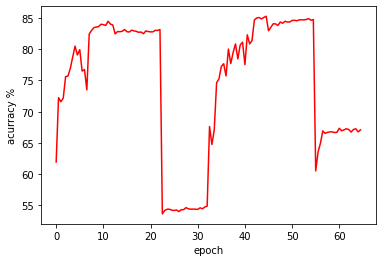

In [ ]:
plot_accuracy(test_accuracy,sum(n_epochs))

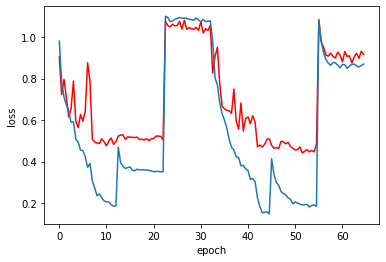

In [ ]:
plot_loss(valid_loss,training_loss,sum(n_epochs))

In [ ]:
print("top-accuracy : ",max(test_accuracy))
      

top-accuracy :  85.275


In [ ]:
get_number_param_pruned(mymodel.model)

params_initiaux :  9228036
nouveaux conv :  3072576.0
nouveaux fc :  612.0


# Version half

Text(0, 0.5, 'Accuracy')

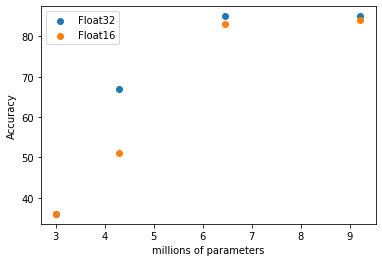

In [ ]:
a= [9.217728,6.445503,4.297002,3.005190]
b=[85,85,67,36]
c=[9.217728,6.445503,4.297002,3.005190]
d=[84,83,51,36]

fig=plt.scatter(a,b)

plt.scatter(c,d)
plt.legend(["Float32","Float16"])
plt.xlabel("millions of parameters")
plt.ylabel("Accuracy")



#pruning specific layers

In [ ]:


net = VGG('VGG16')
if data_int :
  net.half()
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

lr=0.001
n_epochs=[25,20,16]
pruning_coefs=[{"fc":0.7 , "conv":0.3,"dim":0}]

optimizer = optim.SGD(mymodel.model.parameters(), lr=lr, momentum=0.9,weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4)

valid_loss,training_loss,test_accuracy = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[0],criterion,optimizer,mymodel) 

mymodel.prune_all_layers(pruning_coefs[0])
paramconv1,paramfc1=get_number_param_pruned(mymodel.model)

print(paramconv1,paramfc1)

valid_loss1,training_loss1,test_accuracy1 = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[1],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy) 

#torch.save(mymodel.model.state_dict(), 'checkpoint.pt')
state = {
            'net': mymodel.model.state_dict(),
            'scheduler': lr_scheduler,
            'optimizer': optimizer,
    }
torch.save(state, 'checkpoint.pt')

print("___________Phase 1 finie_____________")
print("Accuracy max : ",max(test_accuracy1))
print("_____________________________________")

ratio_conv=[0.3,0.6]
#list_modules=["features.0","features.4","features.8","features.11","features.15","features.18","features.22","features.25"]    VGG11

recap_dic={}
list_modules=[ "features.0",
              "features.3",
              "features.7",
              "features.10",
              "features.14",
              "features.17",
              "features.20",
              "features.24",
              "features.27",
              "features.30",
              "features.34",
              "features.37",
              "features.40"]



for ratios in ratio_conv :  
  print("________________________________________________________")
  print("setting ratio to ",ratios)
  for module in list_modules:
    valid_loss,training_loss,test_accuracy=[],[],[]

    loaded_cpt = torch.load('checkpoint.pt')

    mymodel.model.load_state_dict(loaded_cpt["net"])

    lr_scheduler=loaded_cpt['scheduler']

    optimizer=loaded_cpt['optimizer']


    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
    print("changing module : ", module)
    
    mymodel.prune_spef_layer(module,ratios,2)
    paramconv2,paramfc2=get_number_param_pruned(mymodel.model)
    print(paramconv2,paramfc2)

    valid_loss,training_loss,test_accuracy = trainingwithPrunning(trainloader,validloader,testloader,n_epochs[2],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy)

    recap_dic[str(ratios)+" "+module]={
        "test_acc" :test_accuracy ,
        "valid_loss": valid_loss,
        "training_loss": training_loss ,
        "nbr_param":[paramfc2,paramconv2] ,
    }



NameError: ignored

In [ ]:
/recap_dic[str(ratios)+" "+module]={
        "test_acc" :test_accuracy ,
        "valid_loss": valid_loss,
        "training_loss": training_loss ,
        "nbr_param":[paramfc1,paramfc2,paramconv1,paramconv2] ,
    }

SyntaxError: ignored

0.3 features.0
77.775
[616.0, 10286442.0]

0.3 features.3
81.2
[616.0, 10278207.0]

0.3 features.7
81.525
[616.0, 10269567.0]

0.3 features.10
81.575
[616.0, 10252287.0]

0.3 features.14
81.15
[616.0, 10218111.0]

0.3 features.17
82.1
[616.0, 10149375.0]

0.3 features.20
83.325
[616.0, 10149375.0]

0.3 features.24
82.525
[616.0, 10011903.0]

0.3 features.27
82.75
[616.0, 9736959.0]

0.3 features.30
83.75
[616.0, 9736959.0]

0.3 features.34
83.35
[616.0, 9736959.0]

0.3 features.37
83.45
[616.0, 9736959.0]

0.3 features.40
83.925
[616.0, 9736959.0]

0.6 features.0
62.7
[616.0, 10286037.0]

0.6 features.3
74.4
[616.0, 10269567.0]

0.6 features.7
73.1
[616.0, 10252287.0]

0.6 features.10
77.125
[616.0, 10217727.0]

0.6 features.14
70.2
[616.0, 10149375.0]

0.6 features.17
81.0
[616.0, 10011903.0]

0.6 features.20
78.775
[616.0, 10011903.0]

0.6 features.24
80.95
[616.0, 9736959.0]

0.6 features.27
82.4
[616.0, 9187071.0]

0.6 features.30
83.1
[616.0, 9187071.0]

0.6 features.34
83.65
[616

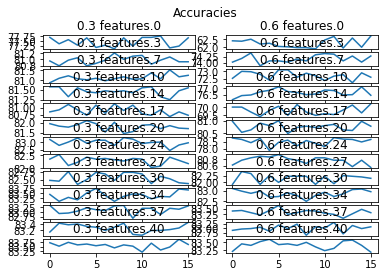

In [ ]:
fig, axs = plt.subplots(13,2)
fig.suptitle('Accuracies')



for key, value in recap_dic.items() :
  if key[:3]==str(0.3):
    y=0
  else :
    y=1
  test_ax=np.arange(0,n_epochs[-1],n_epochs[-1]/len(value["test_acc"]))

  axs[list_modules.index(key[4:]), y].plot(test_ax, value["test_acc"])
  axs[list_modules.index(key[4:]), y].set_title(key)

  print(key)
  print(max(value["test_acc"]))
  print(value["nbr_param"])
  print()
#7,1



In [ ]:

figure=plt.figure(figsize=(10,10))

for key, value in recap_dic.items() :
  #if key[:3]==str(0.3):

  print(key," : ",max(value["test_acc"])," ---- ",sum(value["nbr_param"]))
  plt.scatter(sum(value["nbr_param"]),max(value["test_acc"]))
  

  




plt.legend(recap_dic.keys())
plt.xlabel("millions of parameters")
plt.ylabel("Accuracy")

NameError: ignored

<Figure size 720x720 with 0 Axes>

# Mtn On vire les bons étages

In [ ]:


net = VGG('VGG16')
if data_int :
  net.half()
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

lr=0.1
n_epochs=[100,20,16]
pruning_coefs=[{"fc":0.7 , "conv":0.3,"dim":0}]

optimizer = optim.SGD(mymodel.model.parameters(), lr=lr, momentum=0.9,weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,factor=0.125, patience=5)

valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[0],criterion,optimizer,mymodel) 

mymodel.prune_all_layers(pruning_coefs[0])
paramconv1,paramfc1=get_number_param_pruned(mymodel.model)

print(paramconv1,paramfc1)
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)

valid_loss1,training_loss1,test_accuracy1 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[1],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy) 



print("___________Phase 1 finie_____________")
print("Accuracy max : ",max(test_accuracy1))
print("_____________________________________")




pruned_liste=[[0.6,"features.40"],[0.6,"features.34"],[0.3,"features.30"],[0.6,"features.37"]]



for element in pruned_liste :

    mymodel.prune_spef_layer(element[1],element[0],2)
    paramconv2,paramfc2=get_number_param_pruned(mymodel.model)
    print(paramconv2,paramfc2)

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,factor=0.125, patience=5)
valid_loss2,training_loss2,test_accuracy2 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[2],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy)

    
print(max(test_accuracy2))
print(paramconv2,paramfc2)



NameError: ignored

In [ ]:

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,factor=0.125, patience=5)
valid_loss2,training_loss2,test_accuracy2 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[2],criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy)

NameError: ignored

# Test avec 3 prunage

## 1er entrainement

In [ ]:

data_int=False
net = VGG('VGG16')
if data_int :
  net.half()
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()

lr=0.1
n_epochs=[100,20,10,20,10,20,10]
pruning_coefs=[{"fc":0.9 , "conv":0.3,"dim":0},{"fc":0 , "conv":0.3,"dim":1}]

#premier entrainement
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.1, momentum=0.9,weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,factor=0.125, patience=5)
valid_loss0,training_loss0,test_accuracy0 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[0],criterion,optimizer,mymodel) 


#1er pruning
mymodel.prune_all_layers(pruning_coefs[0])
paramconv0,paramfc0=get_number_param_pruned(mymodel.model)
print(paramconv0,paramfc0)

#2ème entrainement
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss0,training_loss0,test_accuracy0 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[1],criterion,optimizer,mymodel,valid_loss0,training_loss0,test_accuracy0,scheduler=False )

#2ème entrainement bis
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss0,training_loss0,test_accuracy0 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[2],criterion,optimizer,mymodel,valid_loss0,training_loss0,test_accuracy0,scheduler=False ) 

#2ème pruning
mymodel.prune_all_layers(pruning_coefs[1])
paramconv1,paramfc1=get_number_param_pruned(mymodel.model)
print(paramconv1,paramfc1)


#3ème entrainement 
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss0,training_loss0,test_accuracy0 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[3],criterion,optimizer,mymodel,valid_loss0,training_loss0,test_accuracy0,scheduler=False ) 

#3ème entrainement bis
optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss0,training_loss0,test_accuracy0 = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,n_epochs[4],criterion,optimizer,mymodel,valid_loss0,training_loss0,test_accuracy0,scheduler=False ) 








#torch.save(mymodel.model.state_dict(), 'checkpoint.pt')
state = {
            'net': mymodel.model.state_dict(),
            'scheduler': lr_scheduler,
            'optimizer': optimizer,
    }
torch.save(state, 'checkpoint.pt')






print("___________Phase 1 finie_____________")
print("Accuracy max : ",max(test_accuracy))
print("_____________________________________")











epoch  0
saving weights.... 
11.67  % ,  2.3020303283691406  ,  2.417413781929016
epoch  1
saving weights.... 
20.72  % ,  2.066643391418457  ,  2.1081053373336793
epoch  2
saving weights.... 
34.58  % ,  1.73147279586792  ,  1.7918777463912965
epoch  3
saving weights.... 
32.19  % ,  2.4348307025909426  ,  1.5905733932495116
epoch  4
saving weights.... 
32.84  % ,  2.684371448135376  ,  1.443699486351013
epoch  5
saving weights.... 
54.11  % ,  1.3757770265579223  ,  1.2983197905540467
epoch  6
saving weights.... 
54.47  % ,  1.540200781059265  ,  1.184232015800476
epoch  7
saving weights.... 
58.96  % ,  1.3641583070755006  ,  1.1295040771007538
epoch  8
saving weights.... 
54.38  % ,  1.3603452348709106  ,  1.076919110441208
epoch  9
saving weights.... 
60.29  % ,  1.1539476640701294  ,  1.056083007645607
epoch  10
saving weights.... 
67.85  % ,  0.9873358587265014  ,  1.0466141822338104
epoch  11
saving weights.... 
53.51  % ,  1.5343587635040283  ,  1.03401013982296
epoch  12
savi

NameError: ignored

In [ ]:
#from google.colab import drive
from google.colab import files
#drive.mount('/content/drive', force_remount=True)


#files.upload()

files.download('checkpoint.pt')

FileNotFoundError: ignored

## Prune sur les features

In [ ]:
from google.colab import files
import numpy as np
import io
data_int=False
def prune_fine_tune(ind_module,ratio_conv=[0.3,0.6]):
  try: 
    loaded_cpt = torch.load('checkpoint.pt')

  except :


    print("Chargez les poids")
    files.upload()
    loaded_cpt = torch.load('checkpoint.pt')

  
  net = VGG('VGG16')
  
  if data_int :
    net.half()
  mymodel = my_network_with_trous(net)
  mymodel.model = mymodel.model.to(device)
  criterion = nn.CrossEntropyLoss()


  
  recap_dic={}
  dic_save={}
  list_modules=[ "features.0",
              "features.3",
              "features.7",
              "features.10",
              "features.14",
              "features.17",
              "features.20",
              "features.24",
              "features.27",
              "features.30",
              "features.34",
              "features.37",
              "features.40"]
  module=list_modules[ind_module]
  for ratios in ratio_conv :  
    print("________________________________________________________")
    print("setting ratio to ",ratios)
    
    valid_loss,training_loss,test_accuracy=[],[],[]
    

    mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})

    mymodel.model.load_state_dict(loaded_cpt["net"])
    #mymodel.model.load_state_dict(io.BytesIO(loaded_cpt["net"]))

    #lr_scheduler=loaded_cpt['scheduler']

    #optimizer=loaded_cpt['optimizer']


    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
    print("changing module : ", module)
    
    mymodel.prune_spef_layer(module,ratios,2)
    paramconv2,paramfc2=get_number_param_pruned(mymodel.model)
    print(paramconv2,paramfc2)
    # entrainement a

    optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
    valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,20,criterion,optimizer,mymodel,scheduler=False ) 

    #entrainement b

    optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
    valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 


    recap_dic[str(ratios)+" "+module]={
        "test_acc" :test_accuracy ,
        "valid_loss": valid_loss,
        "training_loss": training_loss ,
        "nbr_param":[paramfc2,paramconv2] 
    }
    
    dic_save[str(ratios)+" "+module]={
        "test_acc" :max(test_accuracy) ,
        "nbr_param":[paramfc2,paramconv2] 
    }
  
  try: 
    current_feature=np.load(i+'.npy', allow_pickle='TRUE')
    
    current_feature=current_feature.tolist()

    for key, value in current_feature.items() :
      dic_save[key]=value


  except :
    print("chargez ",i,".npy, si inexistant annuler")
    files.upload()
    try :

      current_feature=np.load(i+'.npy', allow_pickle='TRUE')
      current_feature=current_feature.tolist()

      for key, value in current_feature.items() :
        dic_save[key]=value
      

    except :
      np.save(module+'.npy', dic_save)
      files.download(module+'.npy')


  return recap_dic



  

## Prune sur "features.0"


In [ ]:
prune_fine_tune(0,[0.8,0.875])

Chargez les poids


RuntimeError: ignored

## Prune sur "features.3"

In [ ]:
prune_fine_tune(1,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.3
features.3
7188156.0 510.0
epoch  0
saving weights.... 
83.32  % ,  0.4187791236877441  ,  0.4079273605465889
epoch  1
saving weights.... 
83.88  % ,  0.4018106766104698  ,  0.3540658381551504
epoch  2
saving weights.... 
82.56  % ,  0.4652509907484055  ,  0.33332614375948905
epoch  3
saving weights.... 
85.09  % ,  0.40118082023859025  ,  0.32534253038167954
epoch  4
saving weights.... 
84.33  % ,  0.46513295035362245  ,  0.32141239524483683
epoch  5
saving weights.... 
84.74  % ,  0.4175166788101196  ,  0.3130440088123083
epoch  6
saving weights.... 
83.42  % ,  0.4576169460296631  ,  0.31074335777163503
epoch  7
saving weights.... 
82.12  % ,  0.540731411576271  ,  0.30931447079479696
epoch  8
saving weights.... 
86.11  % ,  0.4185573099374771  ,  0.3087220321804285
epoch  9
saving weights.... 
86.25  % ,  0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.3': {'nbr_param': [510.0, 7188156.0],
  'test_acc': [83.98,
   85.75,
   85.77,
   85.73,
   86.59,
   84.29,
   85.47,
   86.27,
   85.07,
   86.61,
   85.96,
   85.99,
   85.72,
   86.05,
   84.93,
   86.52,
   85.63,
   85.14,
   85.41,
   86.03,
   90.2,
   90.57,
   90.81,
   90.9,
   91.01,
   90.97,
   90.62,
   90.68,
   90.92,
   90.9,
   83.63,
   84.01,
   82.57,
   85.63,
   81.29,
   85.27,
   84.91,
   85.81,
   83.41,
   81.7,
   85.41,
   86.15,
   83.99,
   83.5,
   86.16,
   85.99,
   86.5,
   84.18,
   84.8,
   85.8,
   85.96,
   85.72,
   85.13,
   85.66,
   89.83,
   90.09,
   90.38,
   90.38,
   90.43,
   90.56,
   90.61,
   90.53,
   90.64,
   90.58,
   83.77,
   82.95,
   85.76,
   84.82,
   83.32,
   85.02,
   85.55,
   86.23,
   85.49,
   85.14,
   84.13,
   84.93,
   84.85,
   85.88,
   85.66,
   85.14,
   85.73,
   85.74,
   84.58,
   85.94,
   89.86,
   90.43,
   90.48,
   90.55,
   90.41,
   90.74,
   90.74,
   90.41,
   90.3,
   90.49,
   8

## Prune sur "features.7"

In [ ]:
prune_fine_tune(2,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.7
features.7
7182081.0 510.0
epoch  0
saving weights.... 
83.89  % ,  0.4400855371952057  ,  0.38611446894556284
epoch  1
saving weights.... 
83.57  % ,  0.42904657077789304  ,  0.3432454588383436
epoch  2
saving weights.... 
85.06  % ,  0.4335821806907654  ,  0.3356401875346899
epoch  3
saving weights.... 
84.04  % ,  0.46093476881980894  ,  0.3238153060674667
epoch  4
saving weights.... 
86.81  % ,  0.34980289869308473  ,  0.3230585267543793
epoch  5
saving weights.... 
85.26  % ,  0.3809369330406189  ,  0.3103721905261278
epoch  6
saving weights.... 
86.03  % ,  0.388041846370697  ,  0.30886046421527863
epoch  7
saving weights.... 
84.87  % ,  0.4402124485731125  ,  0.3090041646718979
epoch  8
saving weights.... 
84.79  % ,  0.4331469068050385  ,  0.30337725050747394
epoch  9
saving weights.... 
87.06  % ,  0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.7': {'nbr_param': [510.0, 7182081.0],
  'test_acc': [83.98,
   85.75,
   85.77,
   85.73,
   86.59,
   84.29,
   85.47,
   86.27,
   85.07,
   86.61,
   85.96,
   85.99,
   85.72,
   86.05,
   84.93,
   86.52,
   85.63,
   85.14,
   85.41,
   86.03,
   90.2,
   90.57,
   90.81,
   90.9,
   91.01,
   90.97,
   90.62,
   90.68,
   90.92,
   90.9,
   83.63,
   84.01,
   82.57,
   85.63,
   81.29,
   85.27,
   84.91,
   85.81,
   83.41,
   81.7,
   85.41,
   86.15,
   83.99,
   83.5,
   86.16,
   85.99,
   86.5,
   84.18,
   84.8,
   85.8,
   85.96,
   85.72,
   85.13,
   85.66,
   89.83,
   90.09,
   90.38,
   90.38,
   90.43,
   90.56,
   90.61,
   90.53,
   90.64,
   90.58,
   83.77,
   82.95,
   85.76,
   84.82,
   83.32,
   85.02,
   85.55,
   86.23,
   85.49,
   85.14,
   84.13,
   84.93,
   84.85,
   85.88,
   85.66,
   85.14,
   85.73,
   85.74,
   84.58,
   85.94,
   89.86,
   90.43,
   90.48,
   90.55,
   90.41,
   90.74,
   90.74,
   90.41,
   90.3,
   90.49,
   8

## Prune sur "features.10"


In [ ]:
prune_fine_tune(3,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.10
features.10
7169931.0 510.0
epoch  0
saving weights.... 
84.85  % ,  0.37885906960964205  ,  0.3915827317610383
epoch  1
saving weights.... 
85.14  % ,  0.3813879222869873  ,  0.36015125019550326
epoch  2
saving weights.... 
85.97  % ,  0.36162704025506975  ,  0.3394492732614279
epoch  3
saving weights.... 
86.47  % ,  0.36307315928936007  ,  0.33276546038389204
epoch  4
saving weights.... 
85.85  % ,  0.373699124789238  ,  0.321261684307456
epoch  5
saving weights.... 
84.84  % ,  0.4199017300724983  ,  0.317406006988883
epoch  6
saving weights.... 
84.26  % ,  0.4386263092637062  ,  0.31472248481065035
epoch  7
saving weights.... 
86.4  % ,  0.37494810302257536  ,  0.31368526110053063
epoch  8
saving weights.... 
86.52  % ,  0.38244445865154264  ,  0.30694957921504973
epoch  9
saving weights.... 
86.11  % , 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.10': {'nbr_param': [510.0, 7169931.0],
  'test_acc': [82.52,
   85.01,
   83.73,
   85.0,
   84.73,
   85.54,
   83.11,
   86.34,
   85.08,
   84.93,
   82.78,
   84.63,
   84.43,
   84.6,
   86.08,
   85.62,
   85.56,
   85.69,
   85.79,
   83.26,
   89.8,
   89.89,
   90.32,
   90.63,
   90.6,
   90.71,
   90.71,
   90.78,
   90.7,
   90.6,
   79.68,
   81.94,
   83.57,
   82.51,
   84.51,
   83.98,
   85.53,
   84.25,
   83.95,
   84.22,
   83.95,
   85.34,
   85.96,
   84.3,
   85.46,
   86.59,
   85.51,
   85.05,
   86.36,
   84.16,
   90.02,
   90.22,
   90.7,
   90.59,
   90.58,
   90.48,
   90.64,
   90.22,
   90.63,
   90.55,
   84.85,
   85.14,
   85.97,
   86.47,
   85.85,
   84.84,
   84.26,
   86.4,
   86.52,
   86.11,
   84.97,
   85.45,
   85.45,
   85.88,
   86.5,
   86.6,
   85.16,
   86.44,
   84.81,
   86.56,
   90.24,
   90.62,
   90.87,
   90.99,
   91.08,
   91.25,
   90.89,
   91.03,
   91.26,
   91.05,
   83.79,
   86.59,
   83.8,
   85.63,
   84.

## Prune sur "features.14"


In [ ]:
prune_fine_tune(4,[0.8,0.875])

Chargez les poids


Saving checkpoint.pt to checkpoint.pt
________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.14
features.14
7145901.0 510.0
epoch  0
saving weights.... 
82.52  % ,  0.42210225051641465  ,  0.40907566645145416
epoch  1
saving weights.... 
85.01  % ,  0.35383942351341247  ,  0.360950541138649
epoch  2
saving weights.... 
83.73  % ,  0.4297317171573639  ,  0.35040272166132924
epoch  3
saving weights.... 
85.0  % ,  0.4053603218317032  ,  0.3473049049317837
epoch  4
saving weights.... 
84.73  % ,  0.4291050954580307  ,  0.3275092122018337
epoch  5
saving weights.... 
85.54  % ,  0.3971800770521164  ,  0.3349805044710636
epoch  6
saving weights.... 
83.11  % ,  0.4493438600540161  ,  0.31958931329548357
epoch  7
saving weights.... 
86.34  % ,  0.3755212651491165  ,  0.31514615920186045
epoch  8
saving weights.... 
85.08  % ,  0.4161437240600586  ,  0.3107901745721698
epoc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.14': {'nbr_param': [510.0, 7145901.0],
  'test_acc': [82.52,
   85.01,
   83.73,
   85.0,
   84.73,
   85.54,
   83.11,
   86.34,
   85.08,
   84.93,
   82.78,
   84.63,
   84.43,
   84.6,
   86.08,
   85.62,
   85.56,
   85.69,
   85.79,
   83.26,
   89.8,
   89.89,
   90.32,
   90.63,
   90.6,
   90.71,
   90.71,
   90.78,
   90.7,
   90.6,
   79.68,
   81.94,
   83.57,
   82.51,
   84.51,
   83.98,
   85.53,
   84.25,
   83.95,
   84.22,
   83.95,
   85.34,
   85.96,
   84.3,
   85.46,
   86.59,
   85.51,
   85.05,
   86.36,
   84.16,
   90.02,
   90.22,
   90.7,
   90.59,
   90.58,
   90.48,
   90.64,
   90.22,
   90.63,
   90.55],
  'training_loss': [0.40907566645145416,
   0.360950541138649,
   0.35040272166132924,
   0.3473049049317837,
   0.3275092122018337,
   0.3349805044710636,
   0.31958931329548357,
   0.31514615920186045,
   0.3107901745721698,
   0.3090474818378687,
   0.30886315927356484,
   0.3099342880159616,
   0.31027158932387827,
   0.302051755583286

## Prune sur "features.17"


In [ ]:
prune_fine_tune(5,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.17
features.17
7098108.0 510.0
epoch  0
saving weights.... 
85.68  % ,  0.3673545283079147  ,  0.4165575761258602
epoch  1
saving weights.... 
84.31  % ,  0.391107876932621  ,  0.36688573741316793
epoch  2
saving weights.... 
84.46  % ,  0.424245005774498  ,  0.3547136522620916
epoch  3
saving weights.... 
86.06  % ,  0.38230340807437896  ,  0.3405995216906071
epoch  4
saving weights.... 
83.46  % ,  0.4369804766893387  ,  0.3373549881637096
epoch  5
saving weights.... 
83.73  % ,  0.4667327652692795  ,  0.32738397109508516
epoch  6
saving weights.... 
84.62  % ,  0.42256137087345125  ,  0.32126084246337416
epoch  7
saving weights.... 
87.1  % ,  0.3763585899591446  ,  0.3222502499461174
epoch  8
saving weights.... 
85.3  % ,  0.43210205738544466  ,  0.32008050666749477
epoch  9
saving weights.... 
84.62  % ,  0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.17': {'nbr_param': [510.0, 7098108.0],
  'test_acc': [82.52,
   85.01,
   83.73,
   85.0,
   84.73,
   85.54,
   83.11,
   86.34,
   85.08,
   84.93,
   82.78,
   84.63,
   84.43,
   84.6,
   86.08,
   85.62,
   85.56,
   85.69,
   85.79,
   83.26,
   89.8,
   89.89,
   90.32,
   90.63,
   90.6,
   90.71,
   90.71,
   90.78,
   90.7,
   90.6,
   79.68,
   81.94,
   83.57,
   82.51,
   84.51,
   83.98,
   85.53,
   84.25,
   83.95,
   84.22,
   83.95,
   85.34,
   85.96,
   84.3,
   85.46,
   86.59,
   85.51,
   85.05,
   86.36,
   84.16,
   90.02,
   90.22,
   90.7,
   90.59,
   90.58,
   90.48,
   90.64,
   90.22,
   90.63,
   90.55,
   84.85,
   85.14,
   85.97,
   86.47,
   85.85,
   84.84,
   84.26,
   86.4,
   86.52,
   86.11,
   84.97,
   85.45,
   85.45,
   85.88,
   86.5,
   86.6,
   85.16,
   86.44,
   84.81,
   86.56,
   90.24,
   90.62,
   90.87,
   90.99,
   91.08,
   91.25,
   90.89,
   91.03,
   91.26,
   91.05,
   83.79,
   86.59,
   83.8,
   85.63,
   84.

## Prune sur "features.20"


In [ ]:
prune_fine_tune(6,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.20
features.20
7098108.0 510.0
epoch  0
saving weights.... 
82.38  % ,  0.44386775991916655  ,  0.3860620348814875
epoch  1
saving weights.... 
85.91  % ,  0.3670612971305847  ,  0.3473760468780994
epoch  2
saving weights.... 
83.35  % ,  0.4275624608039856  ,  0.34364650651216505
epoch  3
saving weights.... 
82.6  % ,  0.4840765997886658  ,  0.3364586474478245
epoch  4
saving weights.... 
84.85  % ,  0.3922687263250351  ,  0.32359960429370405
epoch  5
saving weights.... 
84.45  % ,  0.41186701002120973  ,  0.32146553917229176
epoch  6
saving weights.... 
85.95  % ,  0.38272371337413785  ,  0.31804814372062684
epoch  7
saving weights.... 
85.39  % ,  0.41316329424381254  ,  0.31285910589694976
epoch  8
saving weights.... 
86.71  % ,  0.3868884770154953  ,  0.3148858815908432
epoch  9
saving weights.... 
86.42  % 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.20': {'nbr_param': [510.0, 7098108.0],
  'test_acc': [82.52,
   85.01,
   83.73,
   85.0,
   84.73,
   85.54,
   83.11,
   86.34,
   85.08,
   84.93,
   82.78,
   84.63,
   84.43,
   84.6,
   86.08,
   85.62,
   85.56,
   85.69,
   85.79,
   83.26,
   89.8,
   89.89,
   90.32,
   90.63,
   90.6,
   90.71,
   90.71,
   90.78,
   90.7,
   90.6,
   79.68,
   81.94,
   83.57,
   82.51,
   84.51,
   83.98,
   85.53,
   84.25,
   83.95,
   84.22,
   83.95,
   85.34,
   85.96,
   84.3,
   85.46,
   86.59,
   85.51,
   85.05,
   86.36,
   84.16,
   90.02,
   90.22,
   90.7,
   90.59,
   90.58,
   90.48,
   90.64,
   90.22,
   90.63,
   90.55,
   84.85,
   85.14,
   85.97,
   86.47,
   85.85,
   84.84,
   84.26,
   86.4,
   86.52,
   86.11,
   84.97,
   85.45,
   85.45,
   85.88,
   86.5,
   86.6,
   85.16,
   86.44,
   84.81,
   86.56,
   90.24,
   90.62,
   90.87,
   90.99,
   91.08,
   91.25,
   90.89,
   91.03,
   91.26,
   91.05,
   83.79,
   86.59,
   83.8,
   85.63,
   84.

## Prune sur "features.24"


In [ ]:
prune_fine_tune(7,[0.8,0.875])

Chargez les poids


Saving checkpoint.pt to checkpoint.pt
________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.24
features.24
7001985.0 510.0
epoch  0
saving weights.... 
83.82  % ,  0.4152320156812668  ,  0.3753677779302001
epoch  1
saving weights.... 
85.64  % ,  0.3291621312737465  ,  0.3462250084847212
epoch  2
saving weights.... 
84.67  % ,  0.42519748874902724  ,  0.33190153065472844
epoch  3
saving weights.... 
85.43  % ,  0.3677966022372246  ,  0.33085808129012584
epoch  4
saving weights.... 
84.26  % ,  0.42426420383453367  ,  0.31621220431029795
epoch  5
saving weights.... 
83.59  % ,  0.45190358481407167  ,  0.31845793751180174
epoch  6
saving weights.... 
86.91  % ,  0.3446594207048416  ,  0.3156200372368097
epoch  7
saving weights.... 
85.1  % ,  0.4067449975728989  ,  0.30667638978362083
epoch  8
saving weights.... 
85.63  % ,  0.41236174714565277  ,  0.3017140057712793


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.24': {'nbr_param': [510.0, 7001985.0],
  'test_acc': [83.82,
   85.64,
   84.67,
   85.43,
   84.26,
   83.59,
   86.91,
   85.1,
   85.63,
   86.39,
   85.28,
   83.62,
   85.92,
   87.37,
   85.31,
   85.62,
   84.79,
   81.36,
   86.03,
   86.93,
   90.59,
   90.9,
   90.9,
   90.97,
   90.93,
   90.73,
   90.73,
   90.76,
   91.0,
   91.0,
   85.91,
   85.18,
   85.48,
   85.93,
   83.16,
   82.51,
   86.63,
   86.22,
   84.39,
   86.66,
   84.55,
   84.8,
   84.68,
   85.53,
   87.41,
   84.03,
   85.44,
   84.69,
   86.09,
   80.33,
   90.29,
   90.29,
   90.66,
   90.68,
   90.66,
   90.74,
   90.82,
   90.78,
   91.08,
   90.99],
  'training_loss': [0.3753677779302001,
   0.3462250084847212,
   0.33190153065472844,
   0.33085808129012584,
   0.31621220431029795,
   0.31845793751180174,
   0.3156200372368097,
   0.30667638978362083,
   0.3017140057712793,
   0.30335422294437886,
   0.29924887719750404,
   0.2995054669216275,
   0.30042183919698,
   0.2942349959120

## Prune sur "features.27"


In [ ]:
prune_fine_tune(8,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.27
features.27
6809739.0 510.0
epoch  0
saving weights.... 
84.77  % ,  0.333239211666584  ,  0.3685512093707919
epoch  1
saving weights.... 
83.42  % ,  0.42184072368144987  ,  0.3371828979581594
epoch  2
saving weights.... 
85.72  % ,  0.34416522830724716  ,  0.3286381820946932
epoch  3
saving weights.... 
86.82  % ,  0.35359407682418825  ,  0.3241369148075581
epoch  4
saving weights.... 
86.15  % ,  0.36549833872318266  ,  0.3184570017397404
epoch  5
saving weights.... 
83.35  % ,  0.4521233827352524  ,  0.3079734340786934
epoch  6
saving weights.... 
85.23  % ,  0.397946688747406  ,  0.30973900848329067
epoch  7
saving weights.... 
85.55  % ,  0.41473715530633926  ,  0.306109617254138
epoch  8
saving weights.... 
83.15  % ,  0.5183982539653778  ,  0.29709719207584856
epoch  9
saving weights.... 
87.05  % ,  0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.27': {'nbr_param': [510.0, 6809739.0],
  'test_acc': [83.82,
   85.64,
   84.67,
   85.43,
   84.26,
   83.59,
   86.91,
   85.1,
   85.63,
   86.39,
   85.28,
   83.62,
   85.92,
   87.37,
   85.31,
   85.62,
   84.79,
   81.36,
   86.03,
   86.93,
   90.59,
   90.9,
   90.9,
   90.97,
   90.93,
   90.73,
   90.73,
   90.76,
   91.0,
   91.0,
   85.91,
   85.18,
   85.48,
   85.93,
   83.16,
   82.51,
   86.63,
   86.22,
   84.39,
   86.66,
   84.55,
   84.8,
   84.68,
   85.53,
   87.41,
   84.03,
   85.44,
   84.69,
   86.09,
   80.33,
   90.29,
   90.29,
   90.66,
   90.68,
   90.66,
   90.74,
   90.82,
   90.78,
   91.08,
   90.99,
   84.77,
   83.42,
   85.72,
   86.82,
   86.15,
   83.35,
   85.23,
   85.55,
   83.15,
   87.05,
   85.44,
   83.65,
   85.93,
   84.13,
   86.01,
   86.83,
   87.33,
   82.88,
   86.02,
   85.86,
   90.4,
   90.31,
   90.72,
   90.84,
   90.82,
   90.89,
   90.74,
   90.96,
   91.1,
   91.05,
   83.6,
   84.61,
   85.2,
   85.12,
   8

## Prune sur "features.30"


In [ ]:
prune_fine_tune(9,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.30
features.30
6809739.0 510.0
epoch  0
saving weights.... 
85.3  % ,  0.3695487419843674  ,  0.384310731035471
epoch  1
saving weights.... 
83.53  % ,  0.3869398869037628  ,  0.3484098303705454
epoch  2
saving weights.... 
84.39  % ,  0.4132691576957703  ,  0.3305602998241782
epoch  3
saving weights.... 
86.78  % ,  0.35521349189281465  ,  0.3316704084724188
epoch  4
saving weights.... 
85.35  % ,  0.4082661004424095  ,  0.3201140031576157
epoch  5
saving weights.... 
84.93  % ,  0.43268994417190554  ,  0.3171138580173254
epoch  6
saving weights.... 
84.65  % ,  0.4418498308420181  ,  0.30742178422808647
epoch  7
saving weights.... 
85.64  % ,  0.38357009875774384  ,  0.3062221253603697
epoch  8
saving weights.... 
85.23  % ,  0.40524812899827956  ,  0.307082258066535
epoch  9
saving weights.... 
86.67  % ,  0.3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.30': {'nbr_param': [510.0, 6809739.0],
  'test_acc': [83.82,
   85.64,
   84.67,
   85.43,
   84.26,
   83.59,
   86.91,
   85.1,
   85.63,
   86.39,
   85.28,
   83.62,
   85.92,
   87.37,
   85.31,
   85.62,
   84.79,
   81.36,
   86.03,
   86.93,
   90.59,
   90.9,
   90.9,
   90.97,
   90.93,
   90.73,
   90.73,
   90.76,
   91.0,
   91.0,
   85.91,
   85.18,
   85.48,
   85.93,
   83.16,
   82.51,
   86.63,
   86.22,
   84.39,
   86.66,
   84.55,
   84.8,
   84.68,
   85.53,
   87.41,
   84.03,
   85.44,
   84.69,
   86.09,
   80.33,
   90.29,
   90.29,
   90.66,
   90.68,
   90.66,
   90.74,
   90.82,
   90.78,
   91.08,
   90.99,
   84.77,
   83.42,
   85.72,
   86.82,
   86.15,
   83.35,
   85.23,
   85.55,
   83.15,
   87.05,
   85.44,
   83.65,
   85.93,
   84.13,
   86.01,
   86.83,
   87.33,
   82.88,
   86.02,
   85.86,
   90.4,
   90.31,
   90.72,
   90.84,
   90.82,
   90.89,
   90.74,
   90.96,
   91.1,
   91.05,
   83.6,
   84.61,
   85.2,
   85.12,
   8

## Prune sur "features.34"


In [ ]:
prune_fine_tune(10,[0.8,0.875])

Chargez les poids


Saving checkpoint.pt to checkpoint.pt
________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.34
features.34
6809739.0 510.0
epoch  0
saving weights.... 
81.45  % ,  0.445020611679554  ,  0.35084924191869793
epoch  1
saving weights.... 
83.87  % ,  0.43143266570568084  ,  0.33106836324334143
epoch  2
saving weights.... 
86.15  % ,  0.3336475734829903  ,  0.3264572918057442
epoch  3
saving weights.... 
85.34  % ,  0.39070509229898454  ,  0.32258193586170675
epoch  4
saving weights.... 
85.9  % ,  0.37596815447807314  ,  0.30834390057921407
epoch  5
saving weights.... 
86.16  % ,  0.3753319277882576  ,  0.3096859028726816
epoch  6
saving weights.... 
85.47  % ,  0.39195153474807737  ,  0.3019952151685953
epoch  7
saving weights.... 
86.3  % ,  0.3899280695796013  ,  0.3045683059573174
epoch  8
saving weights.... 
85.49  % ,  0.4148231076717377  ,  0.2969441183447838
epo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.34': {'nbr_param': [510.0, 6809739.0],
  'test_acc': [81.45,
   83.87,
   86.15,
   85.34,
   85.9,
   86.16,
   85.47,
   86.3,
   85.49,
   84.39,
   86.94,
   84.58,
   83.76,
   86.98,
   85.56,
   84.68,
   86.86,
   85.73,
   84.84,
   84.46,
   90.46,
   90.74,
   90.62,
   90.88,
   91.03,
   90.94,
   90.82,
   90.76,
   90.96,
   90.95,
   83.39,
   84.83,
   85.22,
   84.36,
   84.2,
   85.99,
   85.64,
   85.06,
   86.18,
   85.07,
   85.59,
   85.3,
   83.05,
   83.72,
   85.13,
   85.88,
   86.78,
   84.97,
   84.54,
   85.23,
   90.37,
   90.71,
   90.88,
   90.79,
   91.04,
   90.69,
   91.11,
   90.89,
   90.89,
   90.87],
  'training_loss': [0.35084924191869793,
   0.33106836324334143,
   0.3264572918057442,
   0.32258193586170675,
   0.30834390057921407,
   0.3096859028726816,
   0.3019952151685953,
   0.3045683059573174,
   0.2969441183447838,
   0.29681066096127035,
   0.29954650689661505,
   0.2892873609080911,
   0.29731301822960376,
   0.288389873

## Prune sur "features.37"


In [ ]:
prune_fine_tune(11,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.37
features.37
6809739.0 510.0
epoch  0
saving weights.... 
84.6  % ,  0.39301682991981507  ,  0.35343674695268273
epoch  1
saving weights.... 
86.78  % ,  0.3161373514652252  ,  0.3337914038449526
epoch  2
saving weights.... 
85.39  % ,  0.39213719725608825  ,  0.3252654498666525
epoch  3
saving weights.... 
85.95  % ,  0.37707878687381746  ,  0.3239388402611017
epoch  4
saving weights.... 
84.75  % ,  0.40358913493156434  ,  0.3091171863377094
epoch  5
saving weights.... 
84.37  % ,  0.446502927339077  ,  0.3079055591315031
epoch  6
saving weights.... 
85.27  % ,  0.40094965193271637  ,  0.30265917486846444
epoch  7
saving weights.... 
85.36  % ,  0.3972926742196083  ,  0.3009394941329956
epoch  8
saving weights.... 
86.16  % ,  0.39943355021476745  ,  0.2980901392430067
epoch  9
saving weights.... 
84.9  % ,  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.37': {'nbr_param': [510.0, 6809739.0],
  'test_acc': [81.45,
   83.87,
   86.15,
   85.34,
   85.9,
   86.16,
   85.47,
   86.3,
   85.49,
   84.39,
   86.94,
   84.58,
   83.76,
   86.98,
   85.56,
   84.68,
   86.86,
   85.73,
   84.84,
   84.46,
   90.46,
   90.74,
   90.62,
   90.88,
   91.03,
   90.94,
   90.82,
   90.76,
   90.96,
   90.95,
   83.39,
   84.83,
   85.22,
   84.36,
   84.2,
   85.99,
   85.64,
   85.06,
   86.18,
   85.07,
   85.59,
   85.3,
   83.05,
   83.72,
   85.13,
   85.88,
   86.78,
   84.97,
   84.54,
   85.23,
   90.37,
   90.71,
   90.88,
   90.79,
   91.04,
   90.69,
   91.11,
   90.89,
   90.89,
   90.87,
   84.6,
   86.78,
   85.39,
   85.95,
   84.75,
   84.37,
   85.27,
   85.36,
   86.16,
   84.9,
   86.11,
   86.11,
   86.44,
   83.47,
   84.73,
   84.59,
   85.8,
   87.58,
   85.14,
   86.18,
   90.33,
   90.59,
   90.99,
   91.02,
   91.2,
   91.28,
   90.96,
   91.09,
   91.02,
   91.31,
   85.36,
   85.19,
   85.88,
   85.78,
  

## Prune sur "features.40"


In [ ]:
prune_fine_tune(12,[0.8,0.875])

________________________________________________________
setting ratio to  0.3
Pruning....
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
changing module :  features.40
features.40
6809739.0 510.0
epoch  0
saving weights.... 
83.74  % ,  0.3652986422300339  ,  0.363784453356266
epoch  1
saving weights.... 
85.42  % ,  0.3625009913682938  ,  0.3371664649128914
epoch  2
saving weights.... 
86.87  % ,  0.334758321750164  ,  0.3273284856915474
epoch  3
saving weights.... 
86.24  % ,  0.3796747834444046  ,  0.3164309662848711
epoch  4
saving weights.... 
84.29  % ,  0.4028608358621597  ,  0.31195530293881896
epoch  5
saving weights.... 
85.03  % ,  0.39987493793964385  ,  0.30701902668476105
epoch  6
saving weights.... 
86.11  % ,  0.38616906170845033  ,  0.30659070705473424
epoch  7
saving weights.... 
86.22  % ,  0.36436377462148667  ,  0.3011259002685547
epoch  8
saving weights.... 
86.58  % ,  0.3698863430172205  ,  0.30108107025027275
epoch  9
saving weights.... 
85.56  % ,  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'0.3 features.40': {'nbr_param': [510.0, 6809739.0],
  'test_acc': [81.45,
   83.87,
   86.15,
   85.34,
   85.9,
   86.16,
   85.47,
   86.3,
   85.49,
   84.39,
   86.94,
   84.58,
   83.76,
   86.98,
   85.56,
   84.68,
   86.86,
   85.73,
   84.84,
   84.46,
   90.46,
   90.74,
   90.62,
   90.88,
   91.03,
   90.94,
   90.82,
   90.76,
   90.96,
   90.95,
   83.39,
   84.83,
   85.22,
   84.36,
   84.2,
   85.99,
   85.64,
   85.06,
   86.18,
   85.07,
   85.59,
   85.3,
   83.05,
   83.72,
   85.13,
   85.88,
   86.78,
   84.97,
   84.54,
   85.23,
   90.37,
   90.71,
   90.88,
   90.79,
   91.04,
   90.69,
   91.11,
   90.89,
   90.89,
   90.87,
   84.6,
   86.78,
   85.39,
   85.95,
   84.75,
   84.37,
   85.27,
   85.36,
   86.16,
   84.9,
   86.11,
   86.11,
   86.44,
   83.47,
   84.73,
   84.59,
   85.8,
   87.58,
   85.14,
   86.18,
   90.33,
   90.59,
   90.99,
   91.02,
   91.2,
   91.28,
   90.96,
   91.09,
   91.02,
   91.31,
   85.36,
   85.19,
   85.88,
   85.78,
  

## Résultats

In [ ]:

from google.colab import files



#files.upload()

#files.download('checkpoint.pt')
 
 
list_modules=[ "features.0",
              "features.3",
              "features.7",
              "features.10",
              "features.14",
              "features.17",
              "features.20",
              "features.24",
              "features.27",
              "features.30",
              "features.34",
              "features.37",
              "features.40"]
list_dico={}
for i in list_modules :


  try: 
    current_feature=np.load(i+'.npy', allow_pickle='TRUE')

  except :
    print("chargez ",i)
    files.upload()
    current_feature=np.load(i+'.npy', allow_pickle='TRUE')

  current_feature=current_feature.tolist()

  for key, value in current_feature.items() :
    list_dico[key]=value



  
  print(list_dico)





chargez  features.0


{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}}
{'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}}
chargez  features.3


Saving features.3.npy to features.3.npy
{'0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}}
{'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}}
chargez  features.7


Saving features.7.npy to features.7.npy
{'0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}}
{'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}}
chargez  features.10


Saving features.10.npy to features.10.npy
{'0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}}
{'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}}
chargez  features.14


Saving features.14.npy to features.14.npy
{'0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}}
{'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}}
chargez  features.

Saving features.17.npy to features.17.npy
{'0.3 features.17': {'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}, '0.6 features.17': {'test_acc': 91.26, 'nbr_param': [510.0, 7001985.0]}}
{'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17':

Saving features.20.npy to features.20.npy
{'0.3 features.20': {'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}, '0.6 features.20': {'test_acc': 91.26, 'nbr_param': [510.0, 7001985.0]}}
{'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17':

Saving features.24.npy to features.24.npy
{'0.3 features.24': {'test_acc': 91.0, 'nbr_param': [510.0, 7001985.0]}, '0.6 features.24': {'test_acc': 91.08, 'nbr_param': [510.0, 6809739.0]}}
{'test_acc': 91.0, 'nbr_param': [510.0, 7001985.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17': {

Saving features.27.npy to features.27.npy
{'0.3 features.27': {'test_acc': 91.1, 'nbr_param': [510.0, 6809739.0]}, '0.6 features.27': {'test_acc': 91.37, 'nbr_param': [510.0, 6425247.0]}}
{'test_acc': 91.1, 'nbr_param': [510.0, 6809739.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17': {

Saving features.30.npy to features.30.npy
{'0.3 features.30': {'test_acc': 91.37, 'nbr_param': [510.0, 6809739.0]}, '0.6 features.30': {'test_acc': 91.37, 'nbr_param': [510.0, 6425247.0]}}
{'test_acc': 91.37, 'nbr_param': [510.0, 6809739.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17':

Saving features.34.npy to features.34 (1).npy
{'0.3 features.34': {'test_acc': 91.03, 'nbr_param': [510.0, 6809739.0]}, '0.6 features.34': {'test_acc': 91.11, 'nbr_param': [510.0, 6425247.0]}}
{'test_acc': 91.03, 'nbr_param': [510.0, 6809739.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.

Saving features.37.npy to features.37 (1).npy
{'0.3 features.37': {'test_acc': 91.31, 'nbr_param': [510.0, 6809739.0]}, '0.6 features.37': {'test_acc': 91.45, 'nbr_param': [510.0, 6425247.0]}}
{'test_acc': 91.31, 'nbr_param': [510.0, 6809739.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.

Saving features.40.npy to features.40 (1).npy
{'0.3 features.40': {'test_acc': 91.45, 'nbr_param': [510.0, 6809739.0]}, '0.6 features.40': {'test_acc': 91.45, 'nbr_param': [510.0, 6425247.0]}}
{'test_acc': 91.45, 'nbr_param': [510.0, 6809739.0]}
<class 'dict'>
{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.

{'0.3 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193961.0]}, '0.6 features.0': {'test_acc': 91.01, 'nbr_param': [510.0, 7193691.0]}, '0.3 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7188156.0]}, '0.6 features.3': {'test_acc': 91.01, 'nbr_param': [510.0, 7182081.0]}, '0.3 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7182081.0]}, '0.6 features.7': {'test_acc': 91.35, 'nbr_param': [510.0, 7169931.0]}, '0.3 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7169931.0]}, '0.6 features.10': {'test_acc': 91.26, 'nbr_param': [510.0, 7145631.0]}, '0.3 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7145901.0]}, '0.6 features.14': {'test_acc': 90.78, 'nbr_param': [510.0, 7097571.0]}, '0.3 features.17': {'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}, '0.6 features.17': {'test_acc': 91.26, 'nbr_param': [510.0, 7001985.0]}, '0.3 features.20': {'test_acc': 91.26, 'nbr_param': [510.0, 7098108.0]}, '0.6 features.20': {'test_acc': 91.26, 'nbr_param': [510

Text(0, 0.5, 'Accuracy')

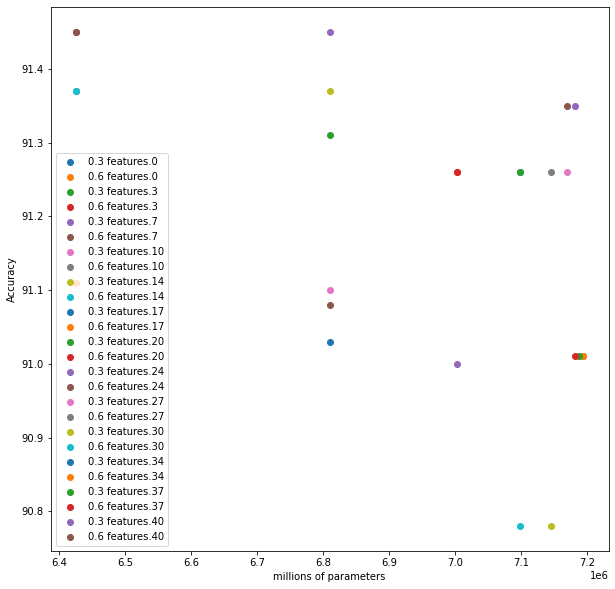

In [ ]:
print(list_dico)



figure=plt.figure(figsize=(10,10))




for key, value in list_dico.items() :
  #if key[:3]==str(0.3):

  print(key," : ",value["test_acc"]," ---- ",sum(value["nbr_param"]))
  plt.scatter(sum(value["nbr_param"]),value["test_acc"])
  


plt.legend(list_dico.keys())
plt.xlabel("millions of parameters")
plt.ylabel("Accuracy")

In [ ]:
try: 
    loaded_cpt = torch.load('checkpoint.pt')

except :


  print("Chargez les poids")
  files.upload()
  loaded_cpt = torch.load('checkpoint.pt')

  
net = VGG('VGG16')
data_int=False
if data_int :
  net.half()
mymodel = my_network_with_trous(net)
mymodel.model = mymodel.model.to(device)
criterion = nn.CrossEntropyLoss()




valid_loss,training_loss,test_accuracy=[],[],[]
    

mymodel.prune_all_layers({"fc":0 , "conv":0,"dim":0})

mymodel.model.load_state_dict(loaded_cpt["net"])

pruning_coefs=[{"fc":0.0 , "conv":0.8,"dim":2}]
mymodel.prune_all_layers(pruning_coefs[0])
paramconv2,paramfc2=get_number_param_pruned(mymodel.model)
print(paramconv2,paramfc2)
# entrainement a

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,20,criterion,optimizer,mymodel,scheduler=False ) 

#entrainement b

optimizer = optim.SGD(mymodel.model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-4)
valid_loss,training_loss,test_accuracy = trainingwithPrunning(c10trainloader,c10validloader,c10testloader,10,criterion,optimizer,mymodel,valid_loss,training_loss,test_accuracy,scheduler=False ) 









Pruning....
Pruning....
2398077.0 510.0
epoch  0
saving weights.... 
36.55  % ,  1.7973972290039062  ,  1.9293569412231446
epoch  1
saving weights.... 
43.66  % ,  1.638041662979126  ,  1.6659474102020264
epoch  2
saving weights.... 
45.55  % ,  1.5829128549575806  ,  1.5451420217990874
epoch  3
saving weights.... 
50.58  % ,  1.435637204170227  ,  1.4655285418510438
epoch  4
saving weights.... 
52.6  % ,  1.398597540473938  ,  1.4089656666278838
epoch  5
saving weights.... 
54.31  % ,  1.3782284767150879  ,  1.3763810025215149
epoch  6
saving weights.... 
53.74  % ,  1.3426942657470704  ,  1.3380230337142944
epoch  7
saving weights.... 
54.49  % ,  1.3312889457702637  ,  1.3186404091835022
epoch  8
saving weights.... 
54.62  % ,  1.3171930965423584  ,  1.292309775018692
epoch  9
saving weights.... 
56.12  % ,  1.2663261310577392  ,  1.2725310539245605
epoch  10
saving weights.... 
55.01  % ,  1.3282194766998292  ,  1.2593284697532654
epoch  11
saving weights.... 
58.39  % ,  1.2321347